# Fiducial Particle Detection in EM Images

Fiducial particles/markers are used in correlated light and electron microscopy (CLEM) to enable accurate overlaying of fluorescence (LM) and electron microscopy (EM) images. The fiducial particles in EM images appear as bright circular regions with dark central spot. 

In this notebook, we **detect fiducial particles** in **EM images** using the template matching algorithm. As a template we use an artificially generated bright image with dark spot in the middle that resembles with its appearence the central part of the fiducial particle. After matching this template to the individual fiducial particles we detect fiducial clusters that consists of at least three fiducial particles in close proximity of each other. The main steps of this algorithm are:
- **1. Fiducial particle detection** - Detection of fiducial particles using the template matching algorithm.
- **2. Cluster detection** - Filtering the set of individual fiducial particles by recognizing clusters of touching fiducial particles and replacing these clusters by their centroid positions.
- **3. Results saving** - Saving the positions of all detected fiducial particles and the positions of fiducial clusters into files.

Load the necessary python libraries:

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import cv2
import math
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from skimage import exposure
import matplotlib.pyplot as plt
#from imutils.object_detection import non_max_suppression
from utils_template_matching import non_max_suppression, template_matching, normalize_image, filter_the_template_matching_results
from utils_template_matching import detect_regions, draw_red_circles
from utils import plot_image, list_to_dataframe, dataframe_to_csv, dataframe_to_xml, dataframe_to_pointcloud

Set the path to the data folder and specify the sample, position and EM image name.
Create the output folder where the algorithm output will be stored.
Load the EM image:

In [4]:
# Load the input folder with EM image

data_folder = 'E:/DATA/AI4Life_Pr26/20240805_Trial_data_fiducial_particles'

# Sample1/pos1
input_folder = os.path.join(data_folder, '240723_JB294_CLEM-AI4life_sample1/pos1')
image_path = Path(os.path.join(input_folder, "240726_JB295_HEK293_CLEM_LAMP1-488_Particles-555_grid4_pos1_bin4_EM.tif"))

# # Sample1/pos2
# input_folder = os.path.join(data_folder, '240723_JB294_CLEM-AI4life_sample1/pos2')
# image_path = Path(os.path.join(input_folder, "240726_JB295_HEK293_CLEM_LAMP1-488_Particles-555_grid4_pos2_bin4_EM.tif"))

# # Sample1/pos3
# input_folder = os.path.join(data_folder, '240723_JB294_CLEM-AI4life_sample1/pos3')
# image_path = Path(os.path.join(input_folder, "240726_JB295_HEK293_CLEM_LAMP1-488_Particles-555_grid4_pos3_bin4_EM.tif"))

# # Sample1/pos4
# input_folder = os.path.join(data_folder, '240723_JB294_CLEM-AI4life_sample1/pos4')
# image_path = Path(os.path.join(input_folder, "240726_JB295_HEK293_CLEM_LAMP1-488_Particles-555_grid4_pos4_bin4_EM.tif"))

# # Sample2/pos1
# input_folder = os.path.join(data_folder, '240730_JB276_CLEM-AI4life_sample2/pos1')
# image_path = Path(os.path.join(input_folder, "240730_JB296_HeLa_CLEM_DHFR2-HA-488_TOMM20-647_JF-particles-555_grid1_pos1_bin4_EM.tif"))

# # Sample2/pos2
# input_folder = os.path.join(data_folder, '240730_JB276_CLEM-AI4life_sample2/pos2')
# image_path = Path(os.path.join(input_folder, "240730_JB296_HeLa_CLEM_DHFR2-HA-488_TOMM20-647_JF-particles-555_grid1_pos2_bin4_EM.tif"))

print(image_path.exists())

# Create the output folder
output_folder = Path(os.path.join(input_folder,"output"))
output_folder.mkdir(exist_ok=True)

# Load the input EM image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

True


Specify the parameters for how the template for the template matching should be created:

In [ ]:
# Size of the template and its value
template_size = 9      # Create an empty template of size ('size','size') filled with constant value - 'value', good value is: 9, 11
template_value = 80    # good value is: 80, 90  (Sample2/pos2 probably needs lower value, like 30)

# Parameters for template matching algorithm
matching_threshold = 0.7   # Threshold for template matching (how good matches are accepted), good value is: 0.7
overlap_threshold = 0.1    # Threshold for non-maximum suppression (how much overlap is allowed between detected regions), good value is: 0.1

# Information about fiducial particles
fiducial_diam = 27     # diameter of fiducial particles in px, to be used in filtering the results

## 1. Fiducial particle detection

### Creating a template for the template matching

Fiducial particles have a very distinct central region, characterized by a dark spot surrounded by a lighter gray region. Instead of attempting to match the entire particle using a full template, we focus on detecting the central region only. To accomplish this, the template can be easily generated artificially. We create an initial example template of size (9,9). This example template will be immediately resized to the desired template size which was set up earlier using parameter 'template_size'.

Using a full particle template did not work satisfactory because of the variaty of the region around the particle. 

In [ ]:
# Create the template as an empty template of size ('size','size') filled with constant value - 'value'
example_template = np.full((9, 9), template_value, dtype=np.uint8) # example template of fixed size 9x9 filled with value 80 is created

# Define the 3x3 pattern - the central dark spot  
template_pattern = np.array([[4, 2, 4],
                             [2, 0, 2],
                             [4, 2, 4]])

# Calculate the starting index to place the pattern in the middle of the template
s_idx = (example_template.shape[0] - template_pattern.shape[0]) // 2
e_idx = s_idx + template_pattern.shape[0]
    
# Place the pattern in the middle of the template
example_template[s_idx:e_idx, s_idx:e_idx] = template_pattern

example_template = example_template.astype(np.uint8)
template = cv2.resize(example_template, (template_size,template_size)) # example template of fixed size 9x9 is rescaled to desired size specified earlier as template_size

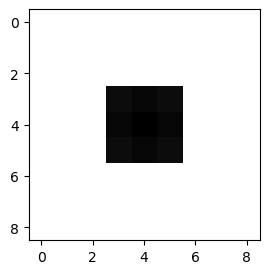

In [8]:
plot_image(template,(3))

Template matching is performed. The matches are first filtered with non-maximum suppression to ensure they are unique and not overlapping. Then we filter false positives by looking at the average intensity in a squared region around the center and at the average intensity in a squared donut area around the center if they fulfill the threshold intensity criteria. The threshold is calculated for each image separately as otsu threshold.

In [ ]:
# Perform template matching
matches, scores = template_matching(normalize_image(image), template, matching_threshold)

# Create bounding boxes
w, h = template.shape[::-1]
boxes = [(x, y, x + w, y + h) for (x, y) in matches]   # coordinates of bounding boxes for each match position 

# Apply non-maximum suppression for filtering out overlapping boxes
keep_ids = non_max_suppression(np.array(boxes), scores, overlap_threshold)

# Center the matches
loc = [np.asarray(matches[keep_id])+[w//2,h//2] for keep_id in keep_ids]

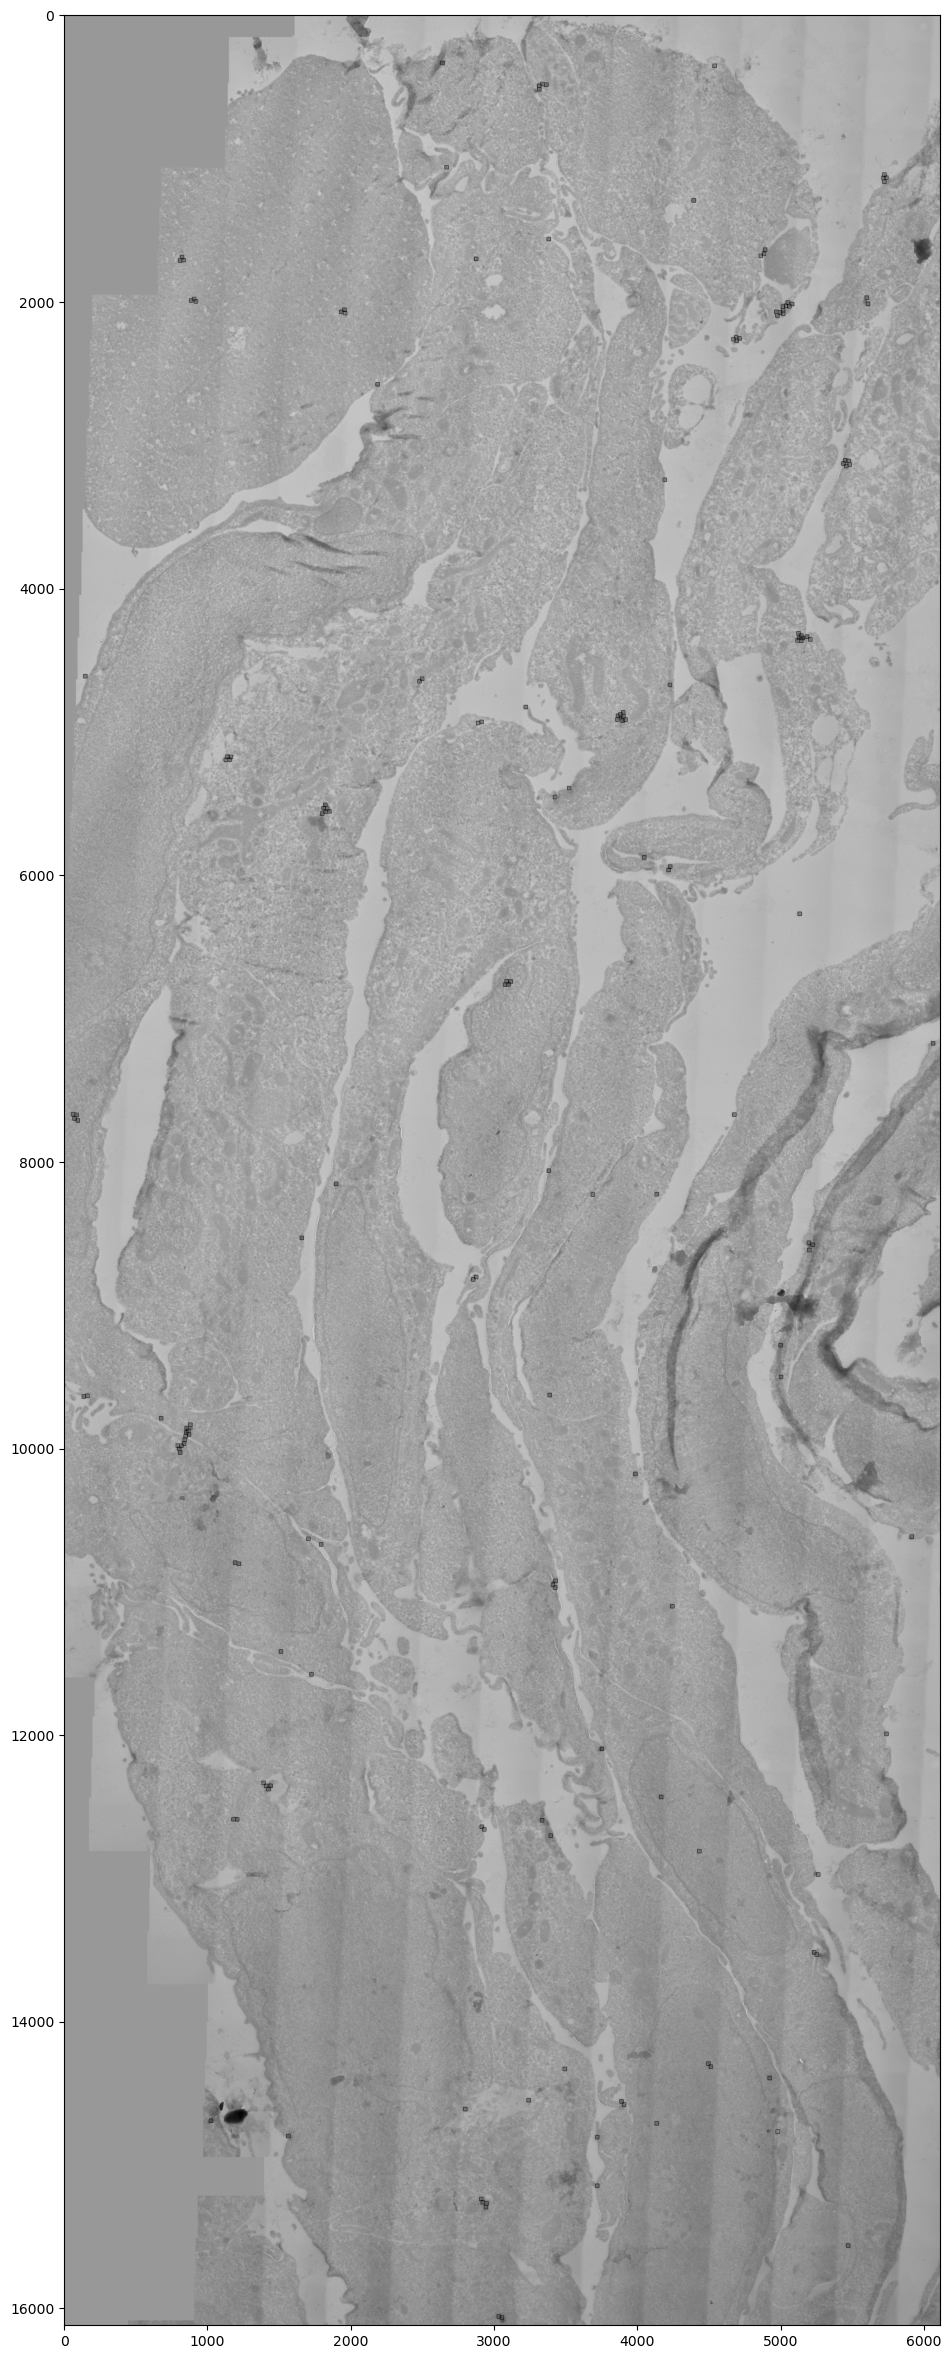

In [ ]:
# Filter the template matching results based on average intensity
radius, out_radius, in_radius = 1, 6, 3           # radius of square, and radius for squared donut around it
locc = filter_the_template_matching_results(loc, normalize_image(image), radius, out_radius, in_radius) # size of middle square, size of outer square, size of inner square for ring

# Draw rectangles around the matched regions
img2 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

for pt in locc:
    cv2.rectangle(img2, (pt[0] - fiducial_diam//2 , pt[1] - fiducial_diam//2 ), (pt[0] + fiducial_diam//2 , pt[1] + fiducial_diam//2), (0, 0, 0), 2)
    
# Correct locations are the ones that are in locc after filtering
loc = locc

cv2.imwrite(str(output_folder/'fiducial_detection_all.png'), img2)
plot_image(img2)

### 2. Cluster detection

After identifying individual fiducial particle (FP) locations, the next step is to detect clusters, which form when multiple FPs are positioned very close to each other. In EM we see them as separate particles, however in LM the resolution is not satisfactory to disstinguish between them and they appear as a single bright spot. 

To identify FP clusters in EM, the fiducial particle mask is dilated using a circular structuring element with a diameter of 7 pixels. Connected components resulting from this dilation are classified as clusters if their area exceeds 3×π×(fiducial_diam//2). The center of each qualifying cluster is recorded as its position.

In contrast, fiducial regions can be defined as connected components with area greater than 1 pixel. This approach preserves isolated FPs while representing groups of FPs as a single point.

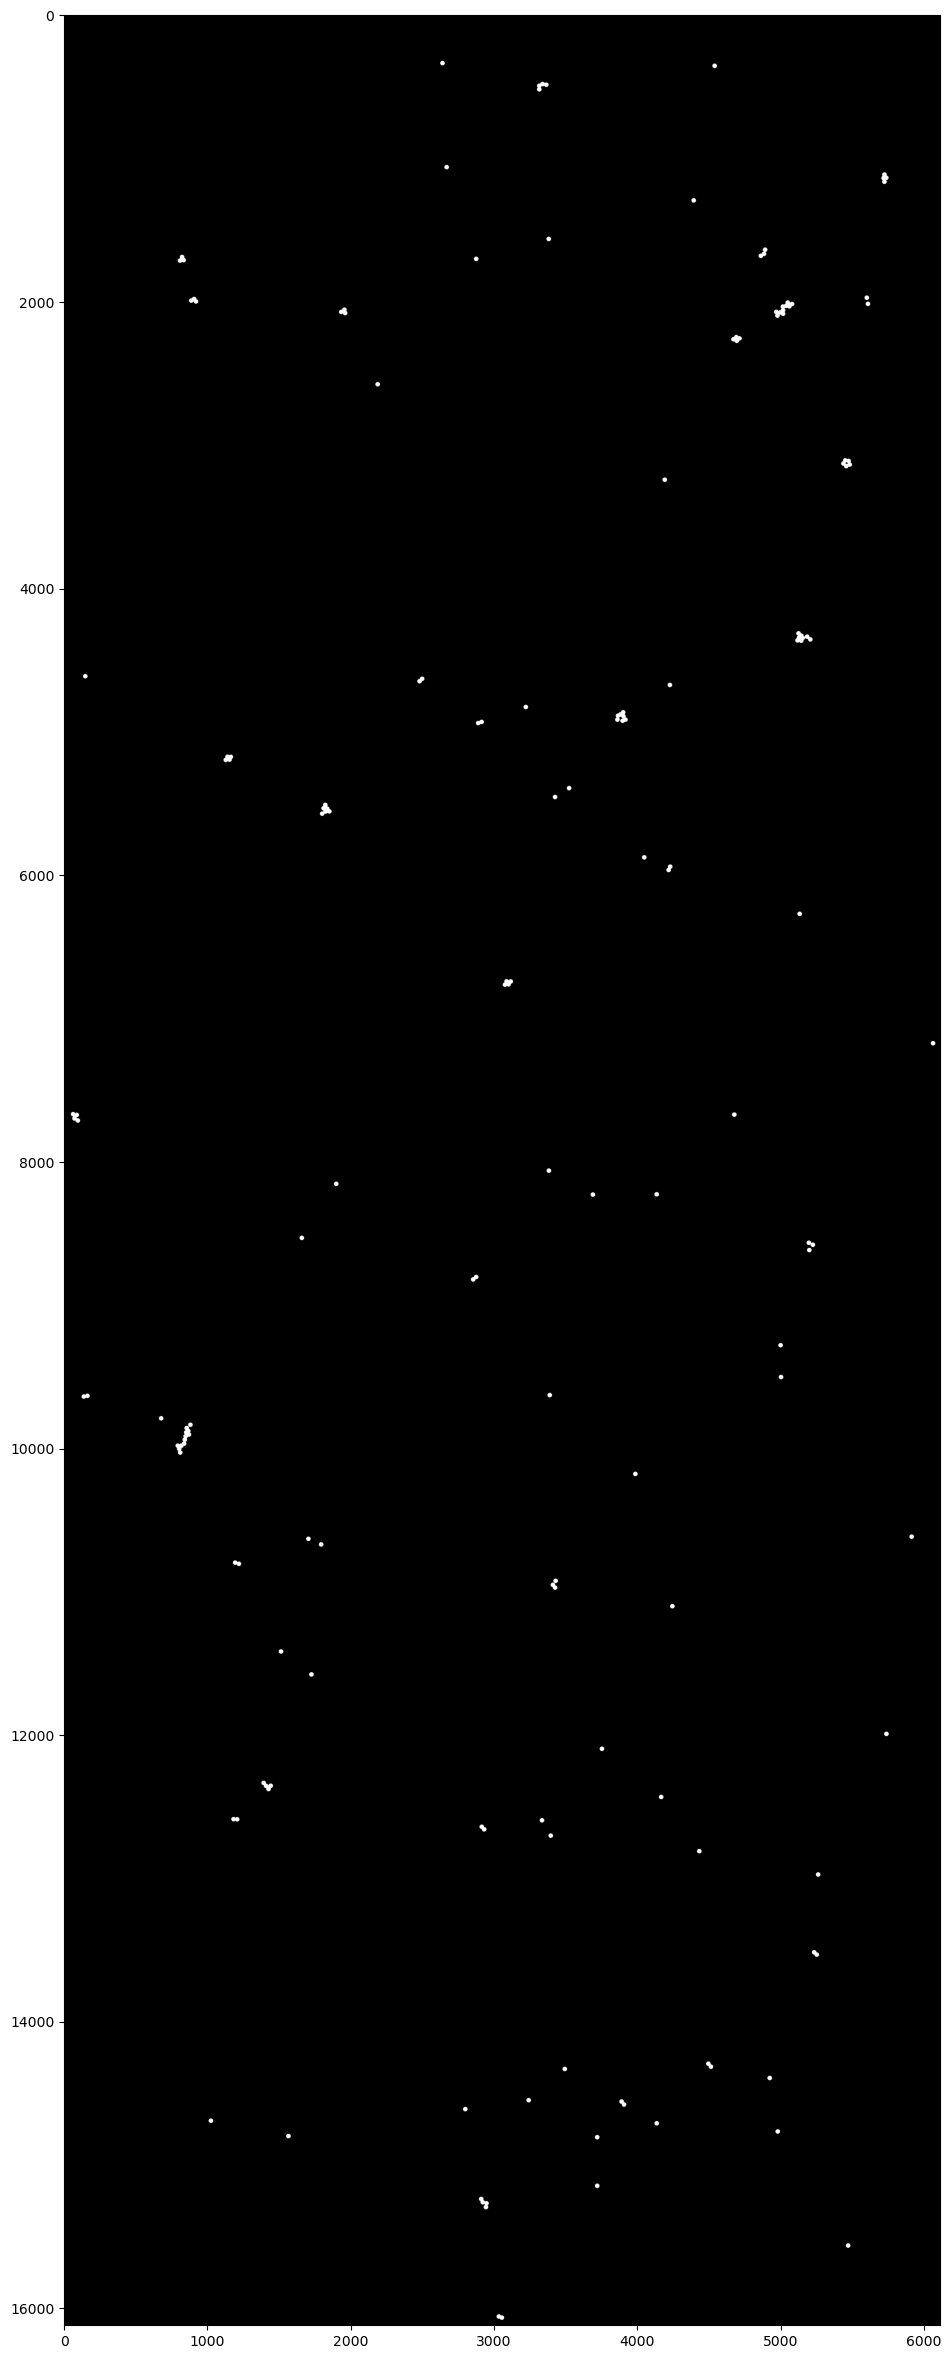

In [7]:
# Create a black image of the same size as img2, then draw filled circles with the radius of FP at the locations 
# of FP taken from the loc variable, dilate the binary image by circular kernel to connect nearby FP, save the image

img_mask = np.zeros_like(img2)
for pt in loc:
    # draw a filled circle around the fiducial particle
    cv2.circle(img_mask, pt, fiducial_diam//2, (255, 255, 255), -1)
    
# Dilate img_mask by circluar kernel of size 7x7
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
img_mask = cv2.dilate(img_mask, kernel, iterations=1)

plot_image(img_mask)
plt.savefig(str(output_folder/'fiducial_detection_mask.png'))


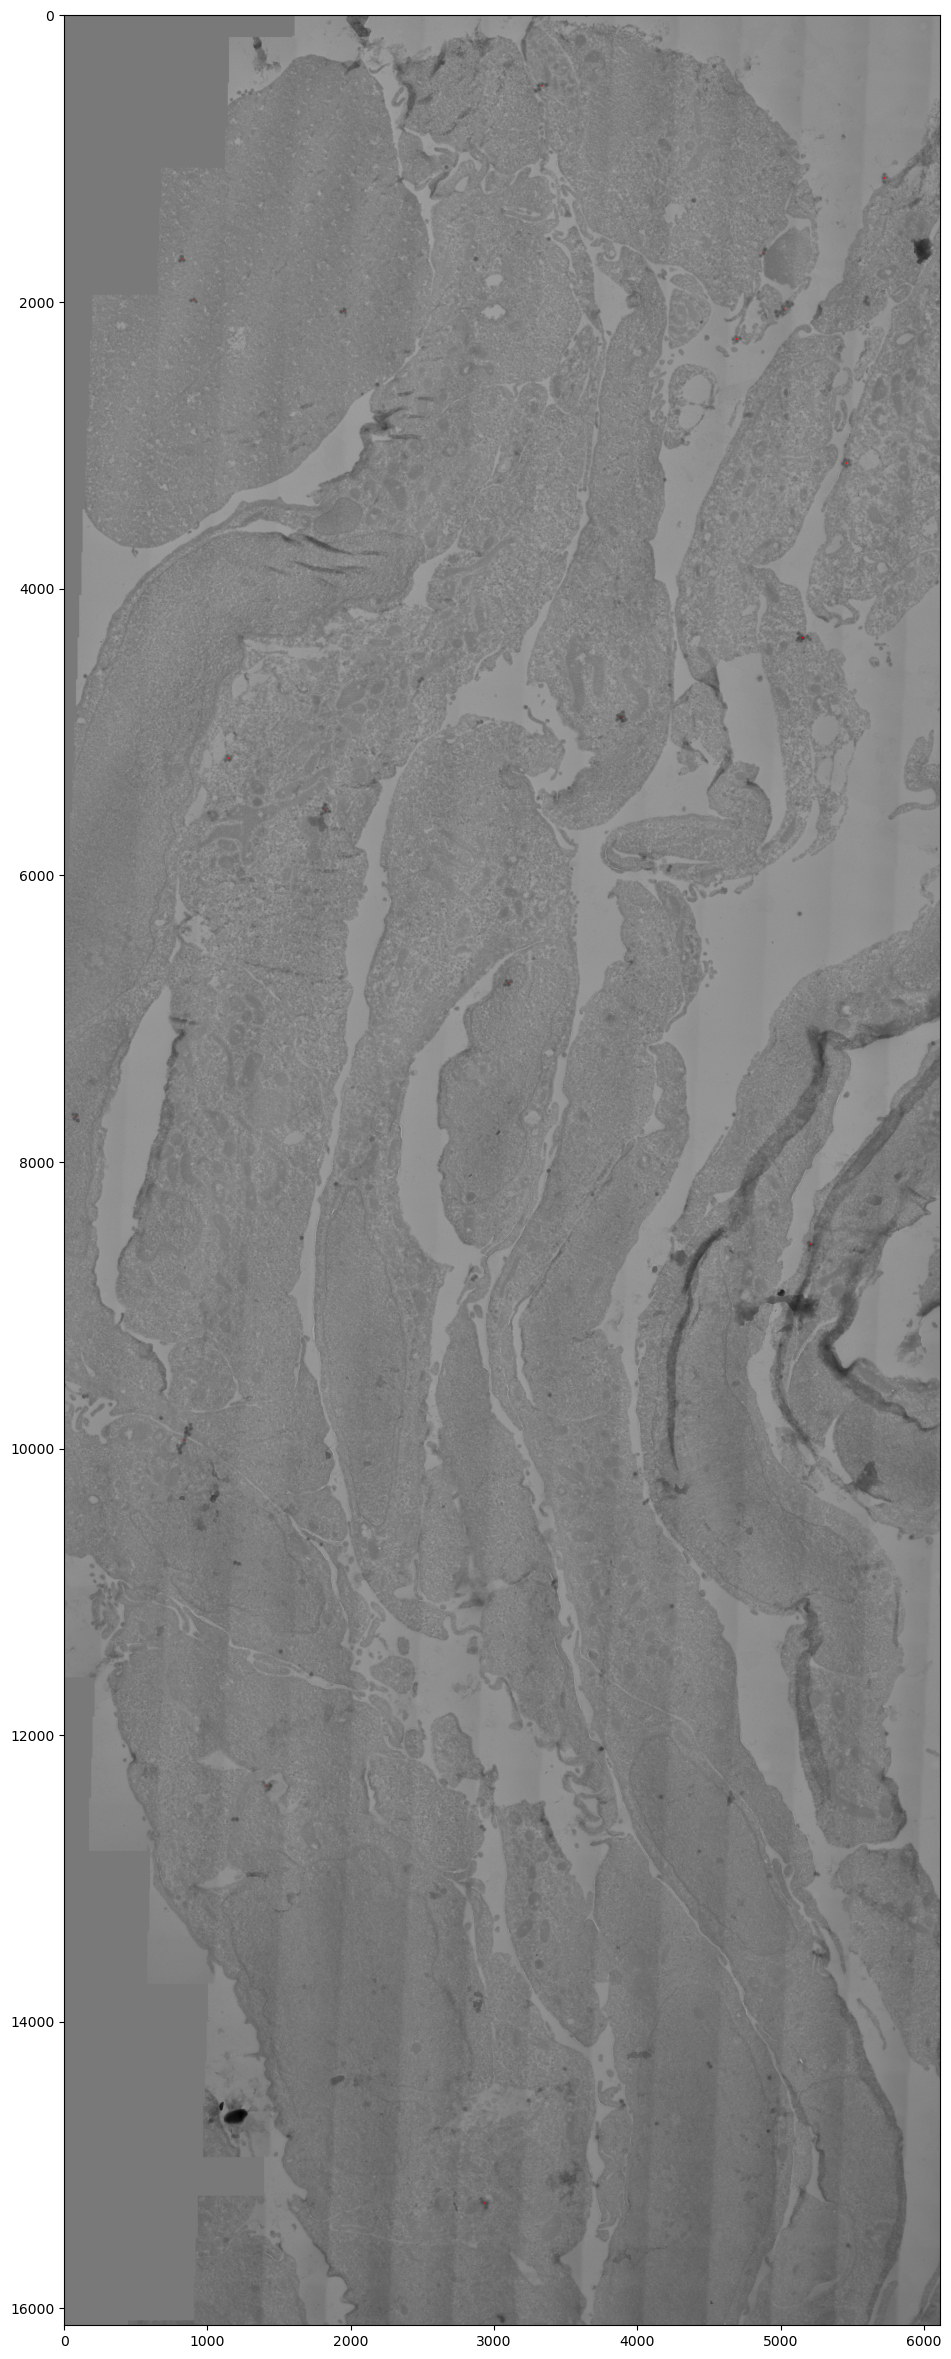

In [ ]:
# Clusters are objects in img_mask with area larger than 3 times the area of fiducial particles
cluster_centroids, cluster_areas = detect_regions(img_mask, (3 * math.pi * (fiducial_diam//2)**2))  # equivalent to the area of 3 fiducial particles

# Regions are objects in img_mask with area larger than 1 px 
regions_centroids, regions_areas = detect_regions(img_mask, 1)  # anything larger than 1 px


# Draw the clusters on the original image
img_clusters = draw_red_circles(image_path, cluster_centroids)
cv2.imwrite(str(output_folder/'fiducial_detection_clusters.png'), img_clusters)
plot_image(img_clusters)

### 3. Results saving

Fiducial particle (FP) locations, together with their filtered counterparts, are first stored in a pandas DataFrame with the columns id, name, pos_x, and pos_y. This ensures a consistent tabular representation of all detected and selected FPs.

The DataFrame is then converted into a NumPy array containing only the (x,y) coordinate pairs for downstream geometric processing. In addition, the FP data are exported to XML and PLY formats to support interoperability with other analysis, visualization, and registration tools.

In [ ]:
# Save all detected fiducial particles into a Pandas dataframe and export it to different file formats
def save_spots_to_diffent_files (spots, folder, file_name, scale):    
    spots_df = list_to_dataframe(spots, os.path.join(folder, f"{file_name}_df.csv"))                                                     #str(output_folder/"source_all_df.csv")

    dataframe_to_xml(spots_df, os.path.join(folder, f"{file_name}.xml"))                      # import file for ICY ec-CLEM plugin
    dataframe_to_xml(spots_df, os.path.join(folder, f"{file_name}_scaled.xml"), scale)                      # import file for ICY ec-CLEM plugin
    dataframe_to_pointcloud(spots_df, os.path.join(folder, f"{file_name}.ply"))                      # import file for point cloud registration using Probgreg package in Python
    dataframe_to_csv(spots_df, os.path.join(folder, f"{file_name}.csv"))                             # import file for BigWarp ImageJ plugin
    return spots_df

scale_x , scale_y = 1, 1
loc_swapped = [(x, y) for y, x in loc]
cluster_centroids_swapped = [(x, y) for y, x in cluster_centroids]
regions_centroids_swapped = [(x, y) for y, x in regions_centroids]

# Save all detected fiducial particles
df1 = save_spots_to_diffent_files(np.unique((loc_swapped), axis=0), output_folder, "target_all", [scale_y, scale_x])  # y and x are swapped in the dataframe

# Save the 'regions'
df2 = save_spots_to_diffent_files(np.unique((regions_centroids_swapped), axis=0), output_folder, "target_regions", [scale_y, scale_x])  # y and x are swapped in the dataframe

# Save the 'clusters'
df3 = save_spots_to_diffent_files(np.unique((cluster_centroids_swapped), axis=0), output_folder, "target_clusters", [scale_y, scale_x])  # y and x are swapped in the dataframe